### Query from waterbox bucket

In [48]:
# 引入相關套件
import influxdb_client
import os
import time
from datetime import datetime, timedelta, timezone
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write_api import SYNCHRONOUS
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# InfluxDB 的令牌和服務器 URL
token = "fP-GBq8Z1wZE7iW8qFBuxVy-ArVP9TqVec0naJ77XLECiwSr82aRXqvo3ylXZqU_2ad2vxWGcMoMbl3PXqAZ7A=="
server_url = "http://140.112.12.62:8086"

# 連接 InfluxDB
client = InfluxDBClient(url=server_url, token=token)
query_api = client.query_api()

# 定義 InfluxDB 查詢語句
query = 'from(bucket: "WaterBox")\
    |> range(start: -200d)\
    |> filter(fn:(r) => r.device_id == "9C65F9448BD3")\
    |> drop(columns: ["_start", "_stop"])'

# 執行 InfluxDB 查詢
result = query_api.query(org="NTUCE", query=query)

# 列印成功連接訊息
print("Connected Successfully")


Connected Successfully


In [18]:
import pandas as pd
from datetime import datetime

# 創建空列表以存儲所有資料
data_list = []

# 逐一遍歷查詢結果並提取資料和時間戳記
for table in result:
    field_name = table.records[0].values['_field']
    data = [data.values['_value'] for data in table.records]
    time = [data.values['_time'] for data in table.records]
    # 將資料存入data_list列表
    data_list.extend({'Field Name': field_name, 'Time': t, 'Data': d} for t, d in zip(time, data))
# 將data_list轉換為pandas的DataFrame
df = pd.DataFrame(data_list)

# 使用pivot_table進行資料重組
pivot_df = df.pivot_table(index='Time', columns='Field Name', values='Data', aggfunc='first')

    # Calculate the 'omega' column by dividing 'bat_a' by 'bat_v'
pivot_df['omega'] = pivot_df['bat_a'] / pivot_df['bat_v']

# 將時間戳記轉換為字串
pivot_df.index = pivot_df.index.astype(str)

# 將DataFrame寫入Excel檔案
excel_filename = 'data_output_' + datetime.now().strftime('%Y%m%d_%H%M%S') + '.xlsx'
pivot_df.to_excel(excel_filename, index=True)

print("資料已成功寫入Excel檔案:", excel_filename)

資料已成功寫入Excel檔案: data_output_20240302_221049.xlsx


In [25]:
import pandas as pd
import openpyxl
from datetime import datetime
from dateutil.relativedelta import relativedelta

# 假設這裡有一個 result 變數，包含查詢結果
# result = ...

# 創建空列表以存儲所有資料
data_list = []

# 逐一遍歷查詢結果並提取資料和時間戳記
for table in result:
    field_name = table.records[0].values['_field']
    data = [data.values['_value'] for data in table.records]
    time = [data.values['_time'] for data in table.records]
    # 將資料存入 data_list 列表
    data_list.extend({'Field Name': field_name, 'Time': t, 'Data': d} for t, d in zip(time, data))

# 將 data_list 轉換為 pandas 的 DataFrame
df = pd.DataFrame(data_list)

# 使用 pivot_table 進行資料重組
pivot_df = df.pivot_table(index='Time', columns='Field Name', values='Data', aggfunc='first')

# 計算 'omega' 欄位
pivot_df['omega'] = pivot_df['bat_a'] / pivot_df['bat_v']

# 將時間戳記轉換為字串
pivot_df.index = pivot_df.index.astype(str)

# 如果 'Time' 是您的索引，請重置索引並轉換為 datetime
pivot_df = pivot_df.reset_index()

# 取得 '年份' 和 '月份'，並加入新的欄位中
pivot_df['Year'] = pd.to_datetime(pivot_df['Time']).dt.year
pivot_df['Month'] = pd.to_datetime(pivot_df['Time']).dt.month

# 將 'Time' 欄位轉換為字串
pivot_df['Time'] = pd.to_datetime(pivot_df['Time']).dt.strftime('%Y-%m-%d %H:%M:%S')

# 將 DataFrame 寫入 Excel 檔案
excel_filename = 'data_output_' + datetime.now().strftime('%Y%m%d_%H%M%S') + '.xlsx'
pivot_df.to_excel(excel_filename, index=True)


# 讀取 Excel 檔案
wb = openpyxl.load_workbook(excel_filename)
ws = wb.active

# 存取第一個時間戳記的年份和月份
first_record_year = pivot_df['Year'].iloc[0]
first_record_month = pivot_df['Month'].iloc[0]

# 更新 Excel 檔案中的標題
ws['L1'] = '年份'
ws['M1'] = '月份'
ws['N1'] = 'pH平均'
ws['O1'] = 'EC平均'
ws['P1'] = '平均換電週期'
print("a")

# 在 K2 中填入第一個記錄的年份
ws['L2'] = first_record_year

# 在 L2 中填入第一個記錄的月份
ws['M2'] = first_record_month
#---------------------------------------
# 計算 H 列的平均值，直到 M 列第一個出現的數字停止
average_H = ws.cell(row=2, column=8).value  # 初始值為 H 列第一個數字
count_H = 1  # 初始值為 1，因為已經包含了第一個數字
count_H2 = 1
end_H = ws.cell(row=2, column=13).value  # 記住最後值的所在位置
# print("a2")
while ws.cell(row=2 + count_H, column=13).value == ws['M2'].value:
    average_H += ws.cell(row=2 + count_H, column=8).value
    count_H += 1
    if ws.cell(row=2 + count_H, column=13).value is None:
        break
count_H2 = count_H
print(count_H)
# print("a3")

average_H /= count_H
# 在 N2 中填入計算的平均值
ws['N2'] = average_H
# print("b")
#----------------------------------------
# 記住上一次迴圈中最後一個值
last_value = ws.cell(row=2 + count_H, column=13).value
average_H2 = ws.cell(row=2 + count_H - 1, column=8).value
# print("c")

# 接下來的迴圈，從上一個迴圈中最後一個值的下一個儲存格開始
while ws.cell(row=2 + count_H, column=13).value == last_value:
    average_H2 += ws.cell(row=2 + count_H, column=8).value
    count_H += 1
    if ws.cell(row=2 + count_H, column=13).value is None:
        break
# print("d")
print(count_H)
print(count_H2)
average_H2 /= (count_H - count_H2)
ws['N3'] = average_H2
print("e")

# Save the Excel file
wb.save(excel_filename)

print("資料、標題及日期已成功寫入 Excel 檔案:", excel_filename)


a
1866
5457
1866
e
資料、標題及日期已成功寫入 Excel 檔案: data_output_20240304_125052.xlsx


In [88]:
import pandas as pd
import openpyxl
from datetime import datetime
from dateutil.relativedelta import relativedelta
from openpyxl.styles import PatternFill
# 引入相關套件
import influxdb_client
import os
import time
from datetime import datetime, timedelta, timezone
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write_api import SYNCHRONOUS
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
'''
# InfluxDB 的令牌和服務器 URL
token = "fP-GBq8Z1wZE7iW8qFBuxVy-ArVP9TqVec0naJ77XLECiwSr82aRXqvo3ylXZqU_2ad2vxWGcMoMbl3PXqAZ7A=="
server_url = "http://140.112.12.62:8086"

# 連接 InfluxDB
client = InfluxDBClient(url=server_url, token=token)
query_api = client.query_api()

# 定義 InfluxDB 查詢語句
query = 'from(bucket: "WaterBox")\
    |> range(start: -250d)\
    |> filter(fn:(r) => r.device_id == "9C65F9448BD3")\
    |> drop(columns: ["_start", "_stop"])'

# 執行 InfluxDB 查詢
result = query_api.query(org="NTUCE", query=query)

# 列印成功連接訊息
print("Connected Successfully")
'''


# 創建空列表以存儲所有資料
data_list = []

# 逐一遍歷查詢結果並提取資料和時間戳記
for table in result:
    field_name = table.records[0].values['_field']
    data = [data.values['_value'] for data in table.records]
    time = [data.values['_time'] for data in table.records]
    # 將資料存入 data_list 列表
    data_list.extend({'Field Name': field_name, 'Time': t, 'Data': d} for t, d in zip(time, data))

# 將 data_list 轉換為 pandas 的 DataFrame
df = pd.DataFrame(data_list)

# 使用 pivot_table 進行資料重組
pivot_df = df.pivot_table(index='Time', columns='Field Name', values='Data', aggfunc='first')

# 計算 'omega' 欄位
pivot_df['omega'] = pivot_df['bat_a'] / pivot_df['bat_v']

# 將時間戳記轉換為字串
pivot_df.index = pivot_df.index.astype(str)

# 如果 'Time' 是您的索引，請重置索引並轉換為 datetime
pivot_df = pivot_df.reset_index()

# 取得 '年份' 和 '月份'，並加入新的欄位中
pivot_df['Year'] = pd.to_datetime(pivot_df['Time']).dt.year
pivot_df['Month'] = pd.to_datetime(pivot_df['Time']).dt.month
pivot_df['Date'] = pd.to_datetime(pivot_df['Time']).dt.day


# 將 'Time' 欄位轉換為字串
pivot_df['Time'] = pd.to_datetime(pivot_df['Time']).dt.strftime('%Y-%m-%d %H:%M:%S')

# 將 DataFrame 寫入 Excel 檔案
excel_filename = 'data_output_' + datetime.now().strftime('%Y%m%d_%H%M%S') + '.xlsx'
pivot_df.to_excel(excel_filename, index=True)


# 讀取 Excel 檔案
wb = openpyxl.load_workbook(excel_filename)
ws = wb.active

# 存取第一個時間戳記的年份和月份
first_record_year = pivot_df['Year'].iloc[0]
first_record_month = pivot_df['Month'].iloc[0]
first_record_date = pivot_df['Date'].iloc[0]


# 更新 Excel 檔案中的標題
ws['L1'] = '年份'
ws['M1'] = '月份'
ws['N1'] = '日期'

# 取得第一個時間戳記的年份和月份
current_year = first_record_year
current_month = first_record_month
current_date = first_record_date

light_blue_fill = PatternFill(start_color='ADD8E6', end_color='ADD8E6', fill_type='solid')
light_yellow_fill = PatternFill(start_color='F9E3A5', end_color='F9E3A5', fill_type='solid')
clear_fill = PatternFill(start_color='FFFFFF', end_color='FFFFFF', fill_type='solid')

ws.column_dimensions['B'].width = 20
ws.column_dimensions['Q'].width = 15
ws.column_dimensions['R'].width = 15
ws.column_dimensions['S'].width = 15
ws['O1'] = '年份'
ws['O1'].fill = light_blue_fill
ws['P1'] = '月份' 
ws['P1'].fill = light_blue_fill
ws['Q1'] = 'pH平均'
ws['Q1'].fill = light_blue_fill
ws['R1'] = 'EC平均'
ws['R1'].fill = light_blue_fill
ws['S1'] = '換電次數'
ws['S1'].fill = light_blue_fill
print("a")

# 在 K2 中填入第一個記錄的年份
ws['L2'] = first_record_year
# 在 L2 中填入第一個記錄的月份
ws['M2'] = first_record_month

# pH 平均值 + 年份月份計算
average_H = 1  # 初始化各個月份平均值
count_H = 1  #  此變數將遍歷表格做計算
count_H2 = 1  #  此變數遍歷單個月份
kH = ws.cell(row=2, column=13).value  # 記住下一個月份的值
nH = 1  # column 13 置頂放置
pH = 0
mouth_H = ws.cell(row=2, column=13).value
year_H = ws.cell(row=2, column=12).value

# EC 平均值 + 平均換電週期
average_G = 1  # 初始化各個月份平均值
count_G = 1  #  此變數將遍歷表格做計算
count_G2 = 1  #  此變數遍歷單個月份
kG = ws.cell(row=2, column=13).value  # 記住下一個月份的值
nG = 1  # column 13 置頂放置
nV = 1  # 計算電壓週期
pG = 0

count_V = 1

test = 0

ws.cell(row=2, column=15, value = year_H)
ws.cell(row=2, column=15).fill = light_yellow_fill
ws.cell(row=2, column=16, value = mouth_H)
ws.cell(row=2, column=16).fill = light_yellow_fill
# 遍歷所有資料、月份，加總並計算 pH 平均
while ws.cell(row=2 + count_H, column=13).value is not None:
    average_H = 1
    while ws.cell(row=2 + count_H, column=13).value == kH:
        average_H += ws.cell(row=2 + count_H, column=8).value
        count_H += 1
    year_H = ws.cell(row=2 + count_H, column=12).value
    mouth_H = ws.cell(row=2 + count_H, column=13).value
    
    average_H /= (count_H - count_H2)
    count_H2 = count_H
    
    ws.cell(row=nH + 2, column=15, value = year_H)  # 寫入年份
    ws.cell(row=nH + 2, column=15).fill = light_yellow_fill
    ws.cell(row=nH + 2, column=16, value = mouth_H)  # 寫入月份
    ws.cell(row=nH + 2, column=16).fill = light_yellow_fill
    if ws.cell(row=2 + count_H, column=13).value is None:
        ws.cell(row=nH + 2, column=15).fill = PatternFill(fill_type=None)
        ws.cell(row=nH + 2, column=16).fill = PatternFill(fill_type=None)
    
    ws.cell(row=nH + 1, column=17, value = average_H)  # 寫入 pH 平均
    ws.cell(row=nH + 1, column=17).fill = light_yellow_fill
    
    nH += 1
    kH = ws.cell(row=2 + count_H, column=13).value
    pH += 1


    # 遍歷所有資料、月份，加總並計算 EC 平均
    average_G = 1
    count_V = 1
    while ws.cell(row=2 + count_G, column=13).value == kG:
        if ws.cell(row=2 + count_G, column=7).value != 0:
            average_G += ws.cell(row=2 + count_G, column=7).value
            test += 1
        if abs(float(ws.cell(row=2 + count_G, column=4).value) - float(ws.cell(row=1 + count_G, column=4).value)) >= 0.2:
            count_V += 1
        
        count_G += 1
    average_G /= (count_G - count_G2)
    count_G2 = count_G
    ws.cell(row=nG + 1, column=18, value=average_G)  # 存入第十八列的位置
    ws.cell(row=nG + 1, column=18).fill = light_yellow_fill
    ws.cell(row=nG + 1, column=19, value=count_V)
    nG += 1
    kG = ws.cell(row=2 + count_G, column=13).value
    pG += 1


print(test)
# 存檔
wb.save(excel_filename)
print("資料、標題及日期已成功寫入 Excel 檔案:", excel_filename)


a
9451
資料、標題及日期已成功寫入 Excel 檔案: data_output_20240307_131016.xlsx


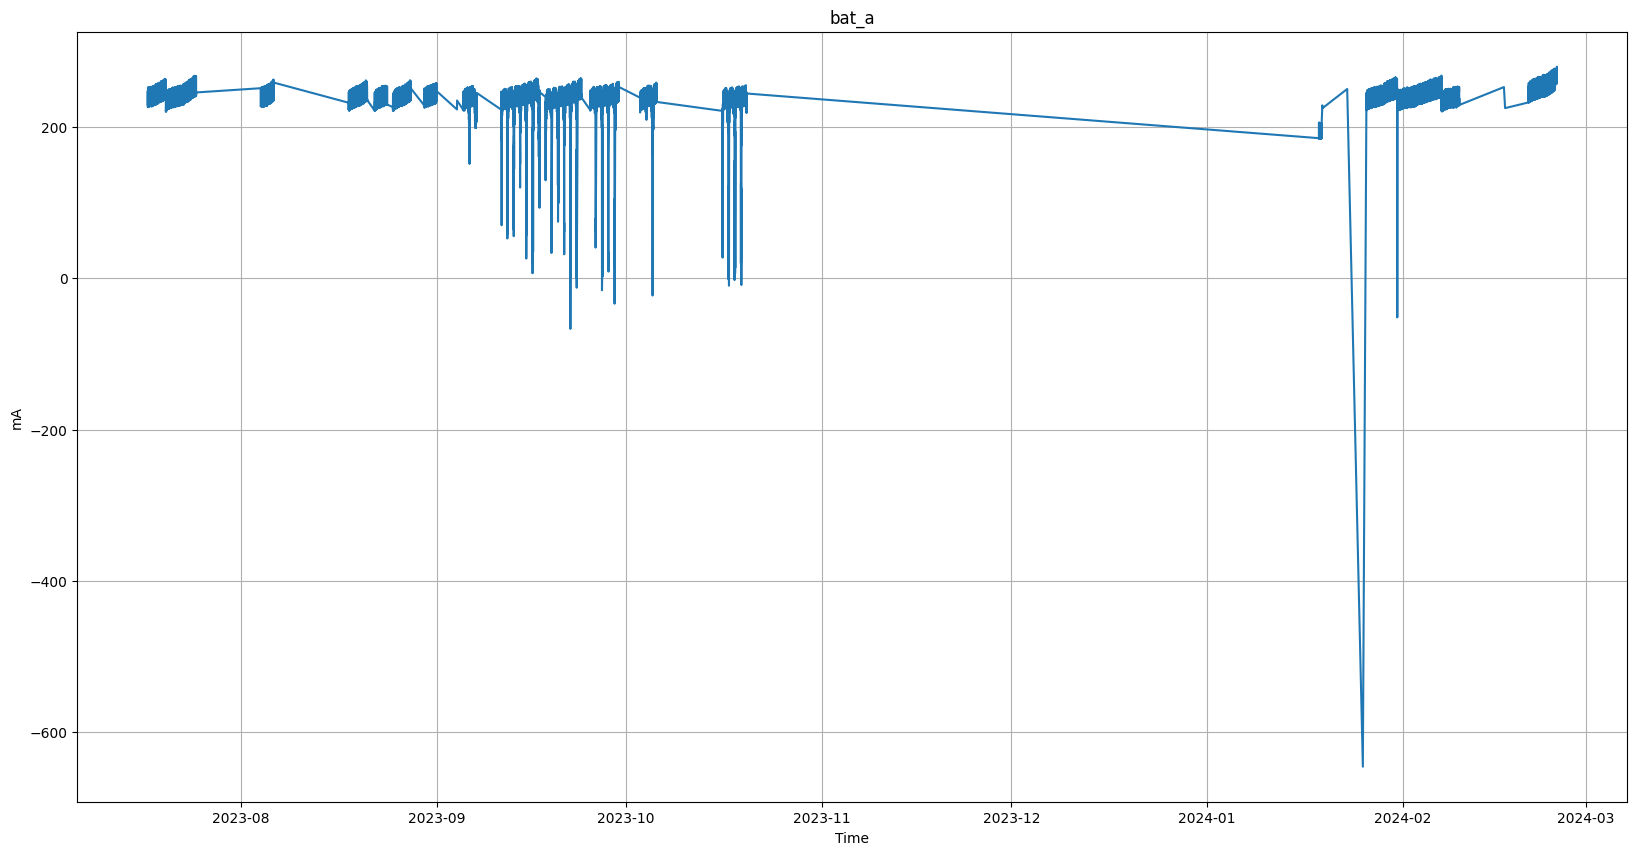

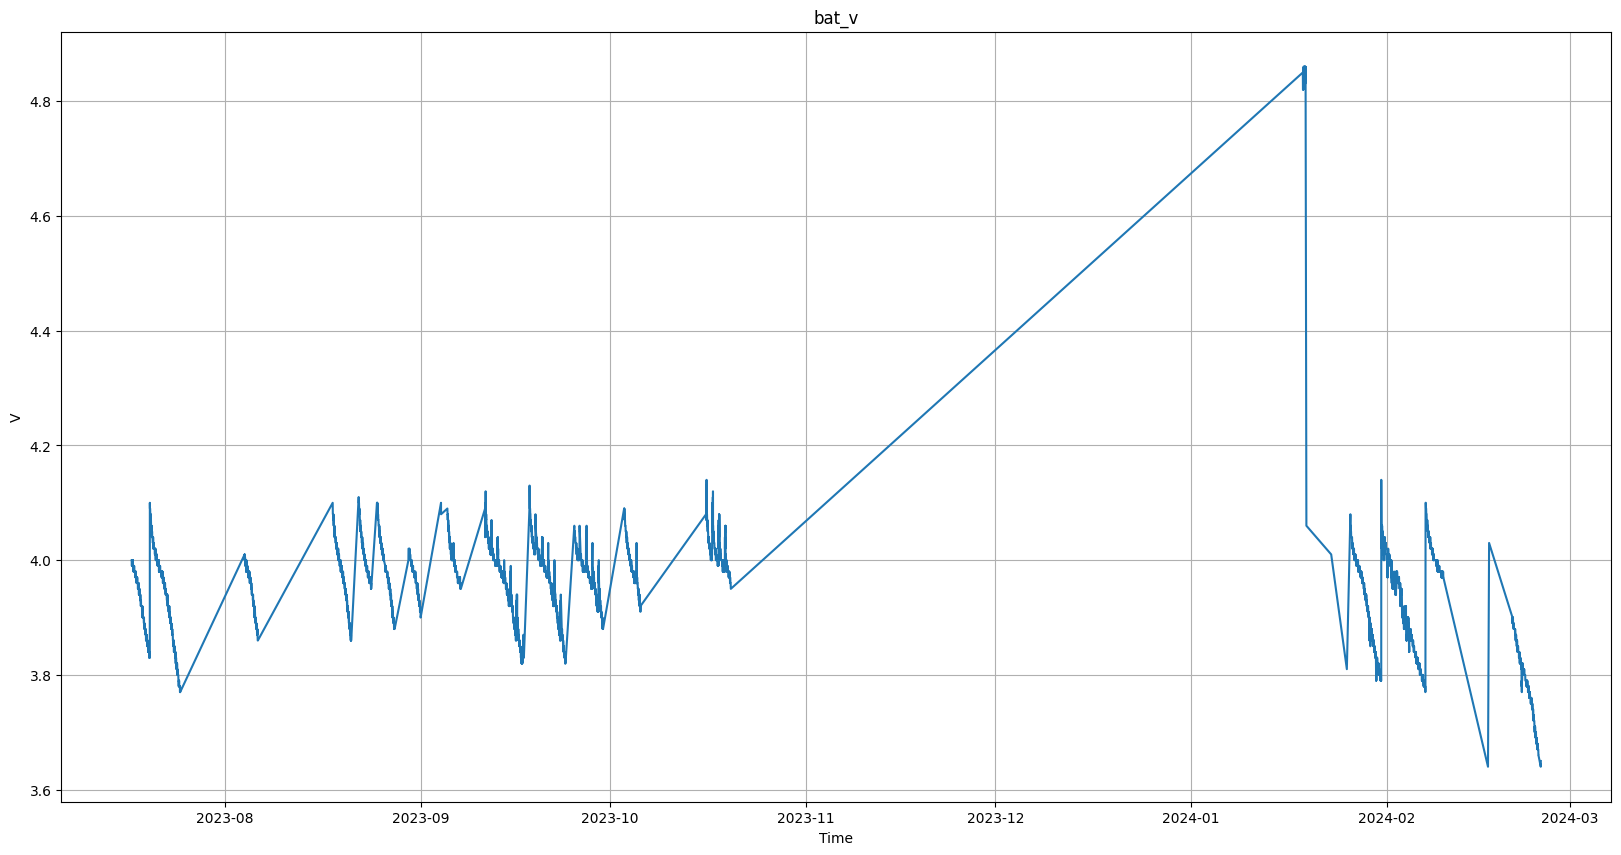

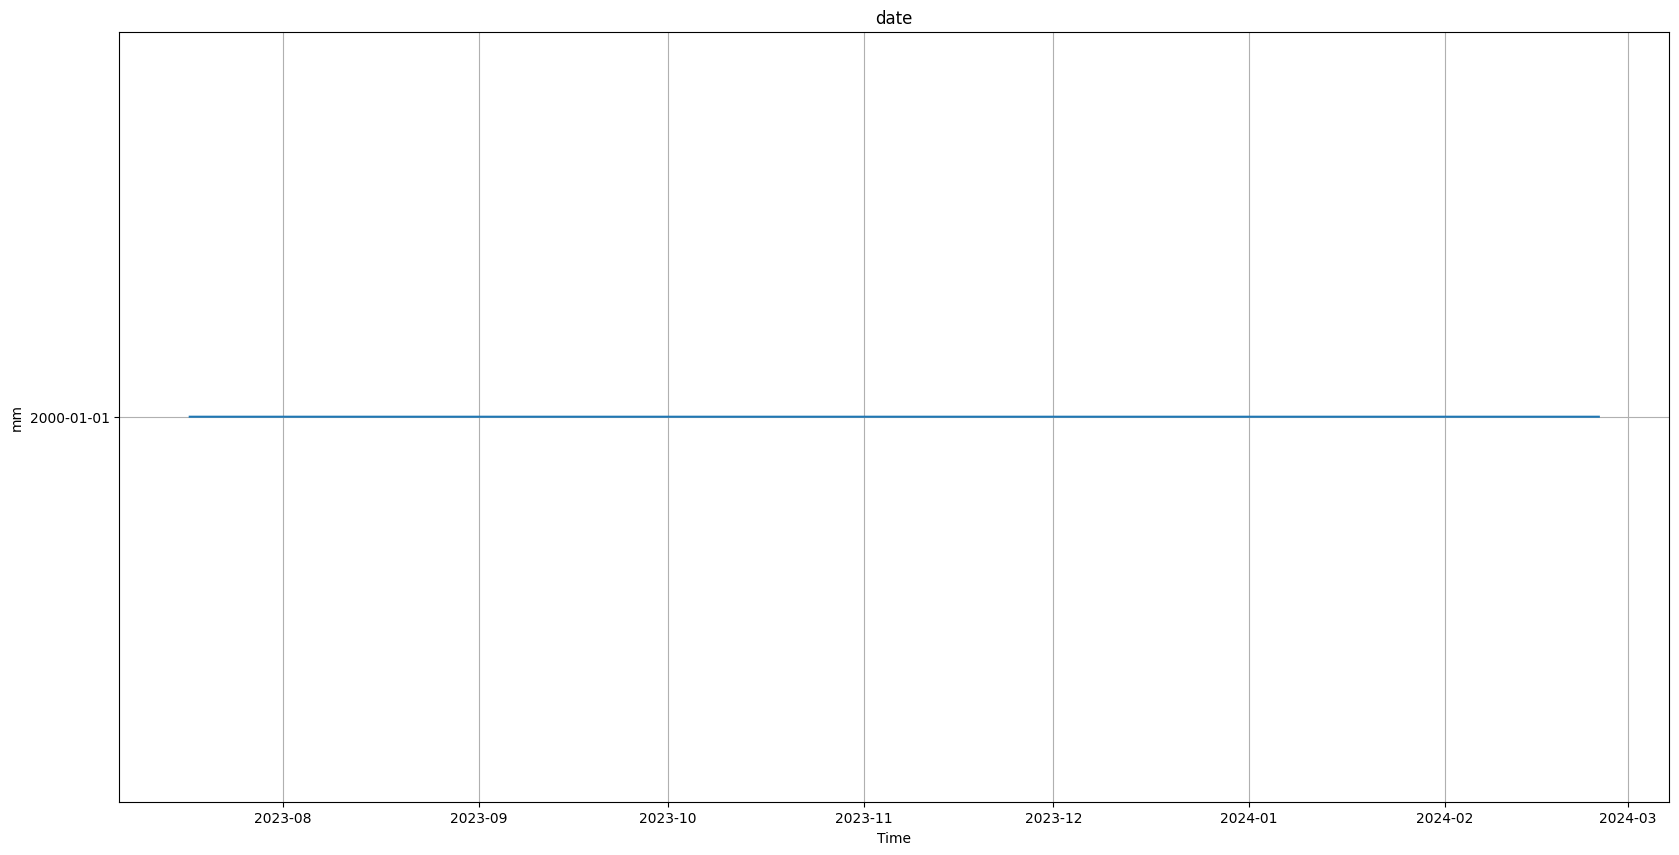

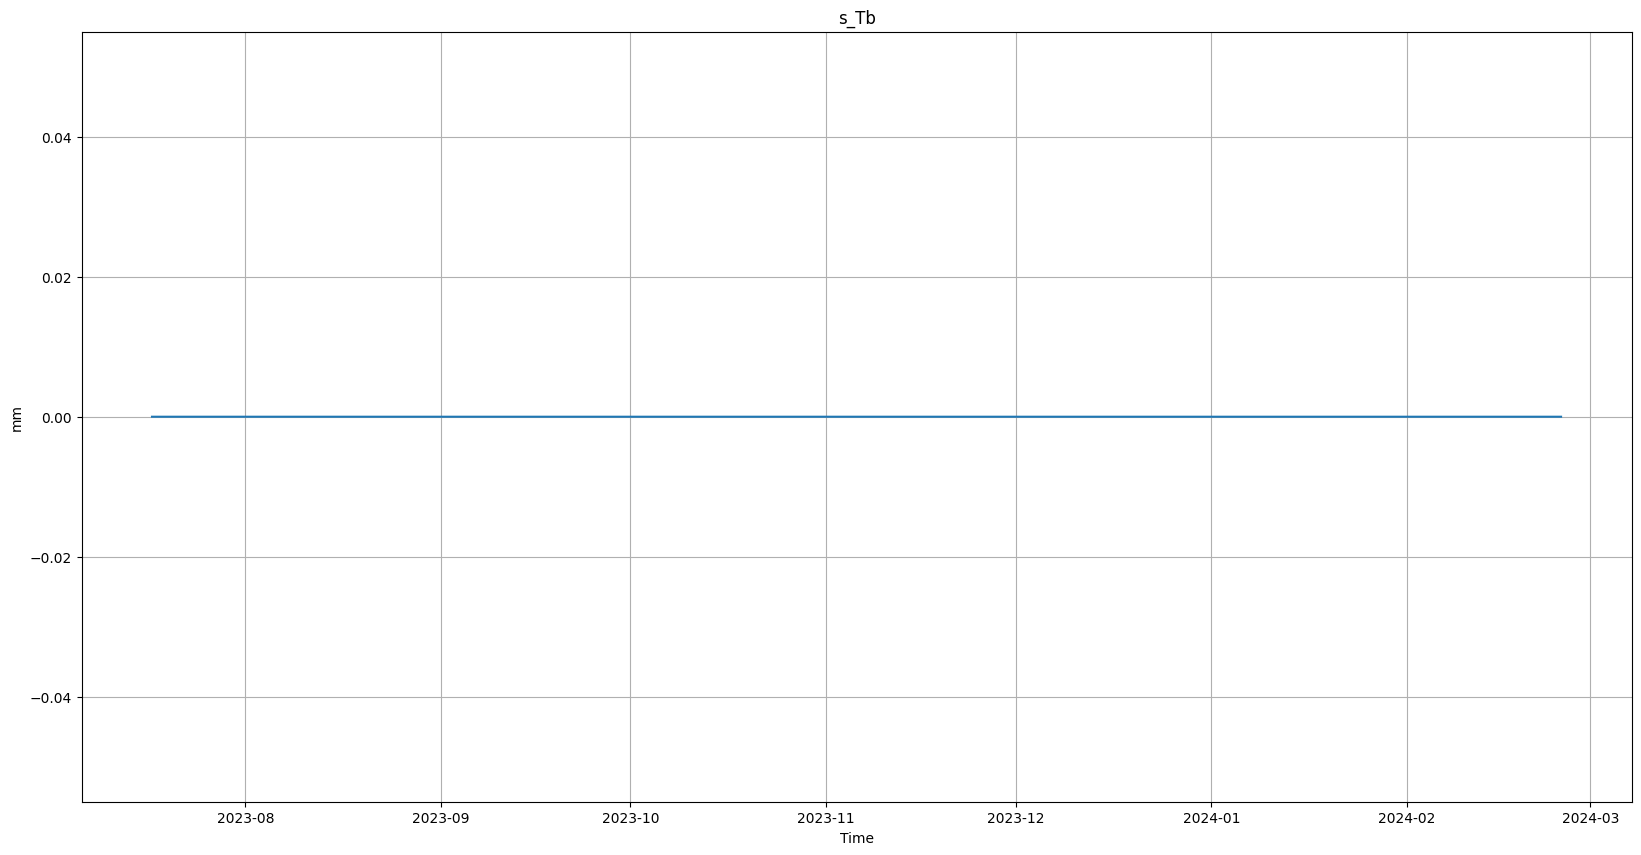

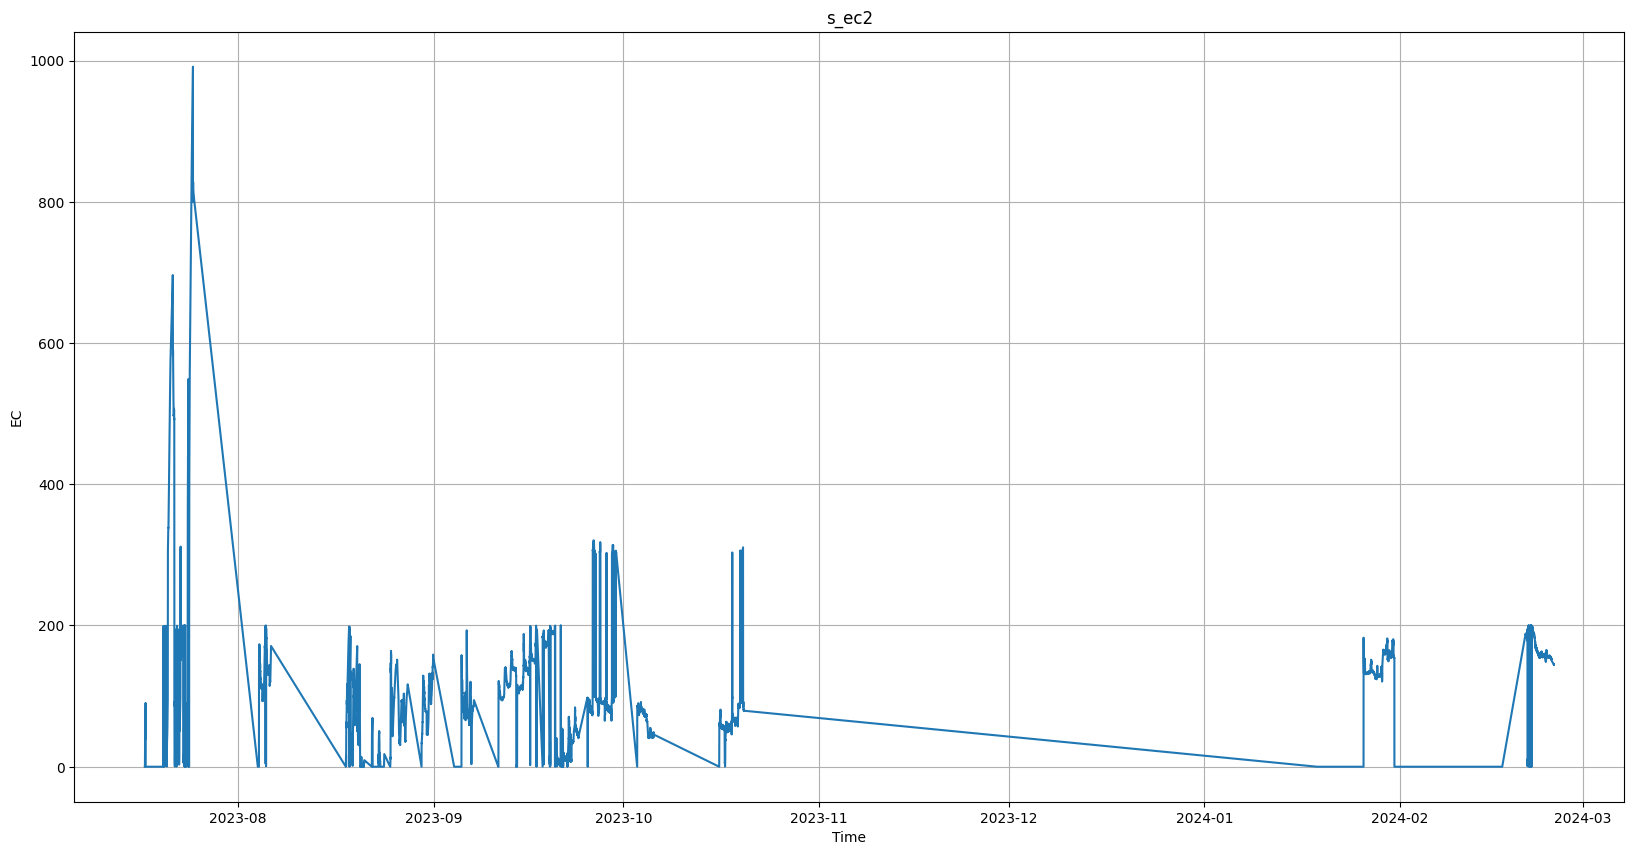

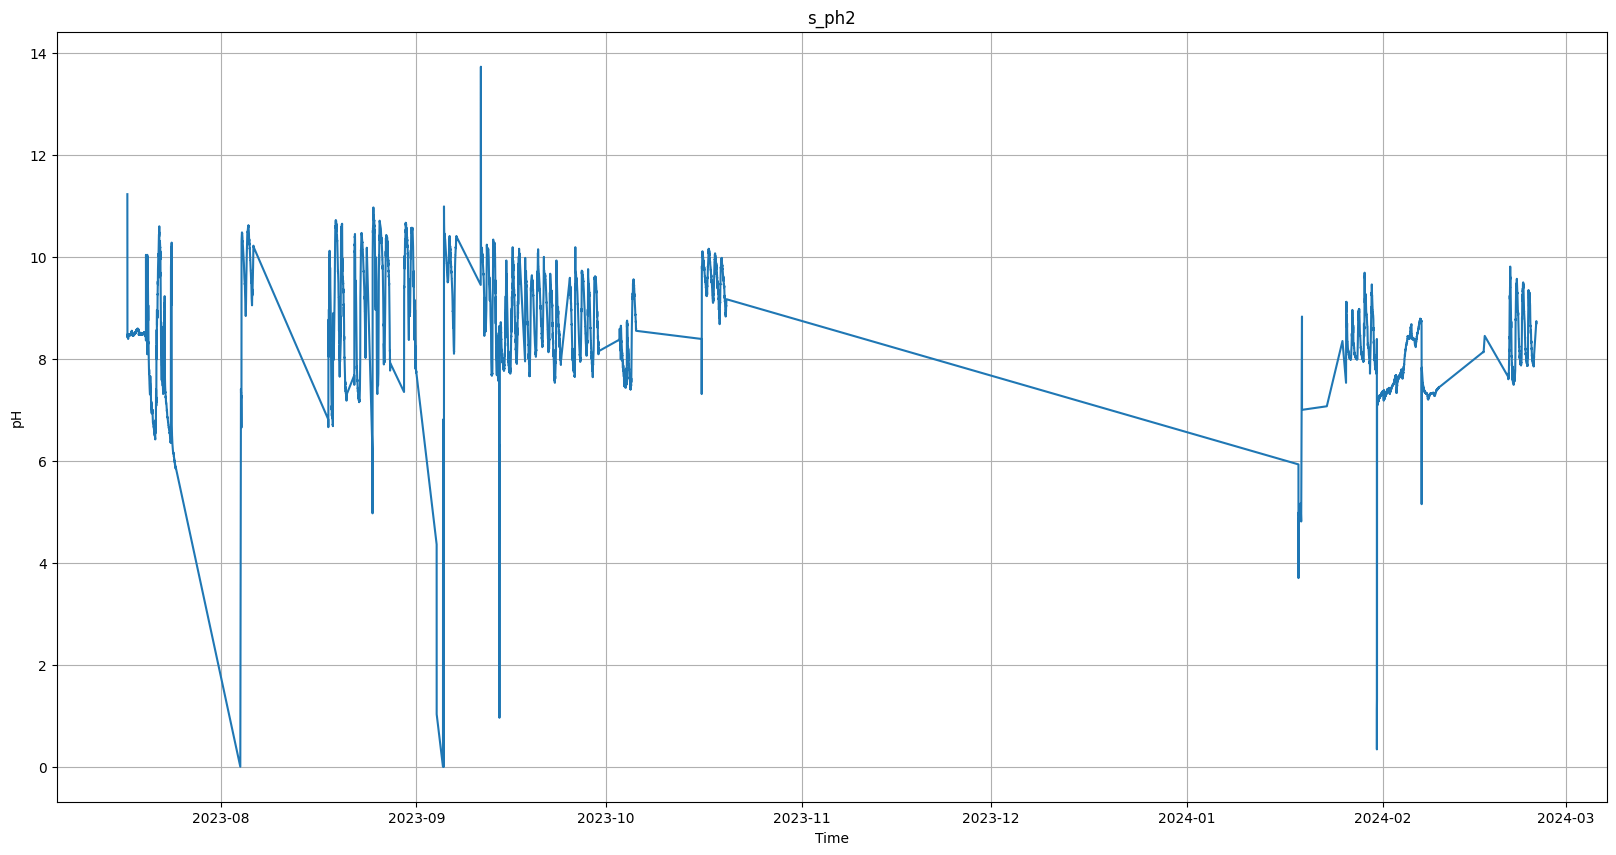

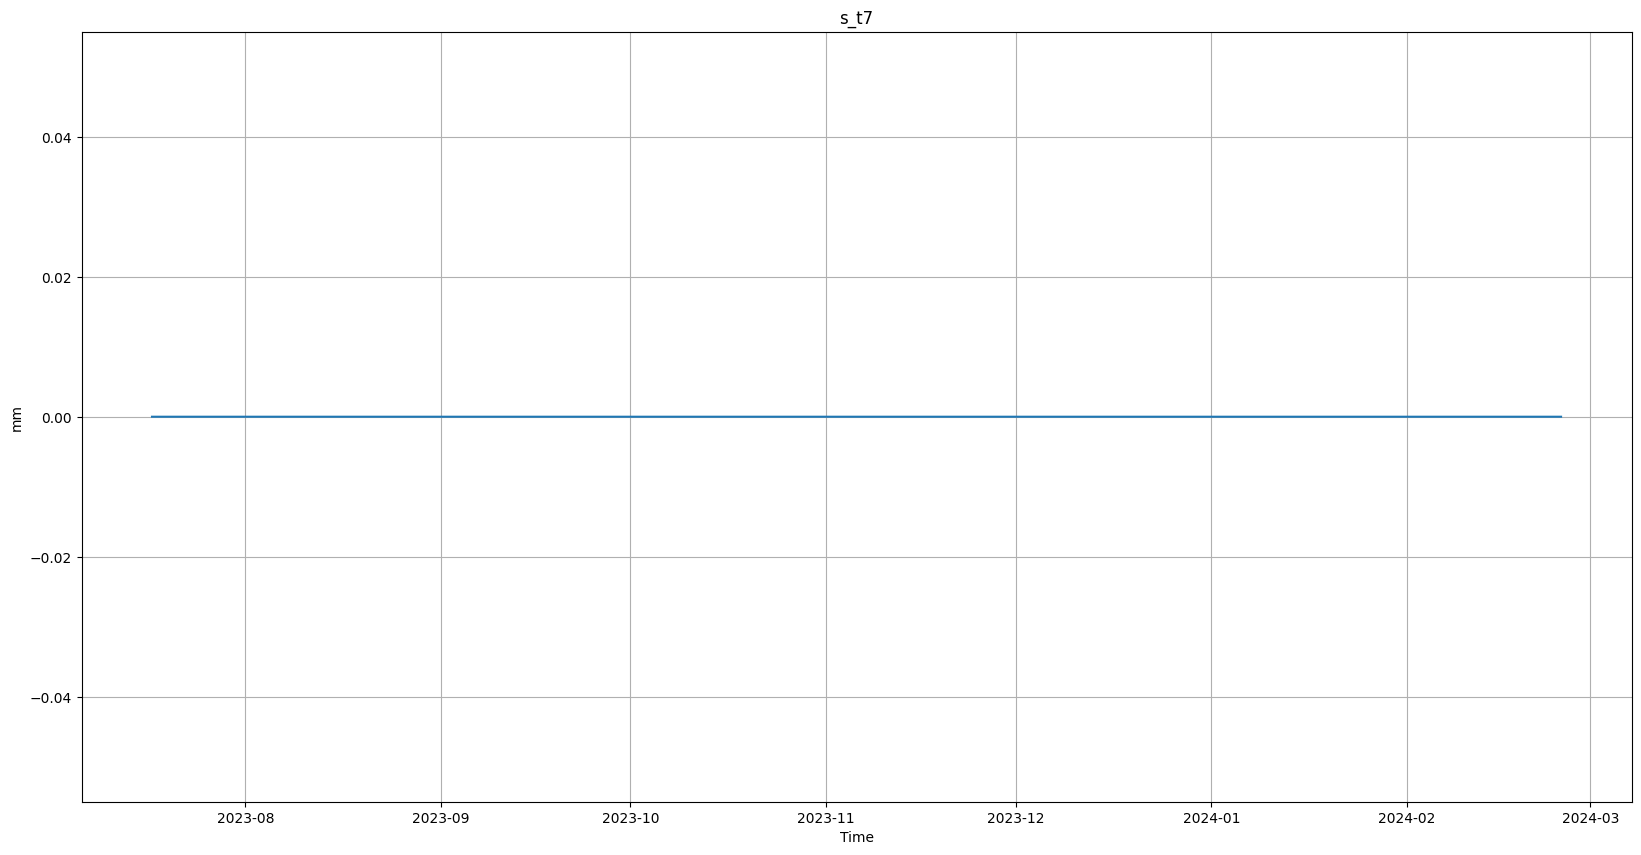

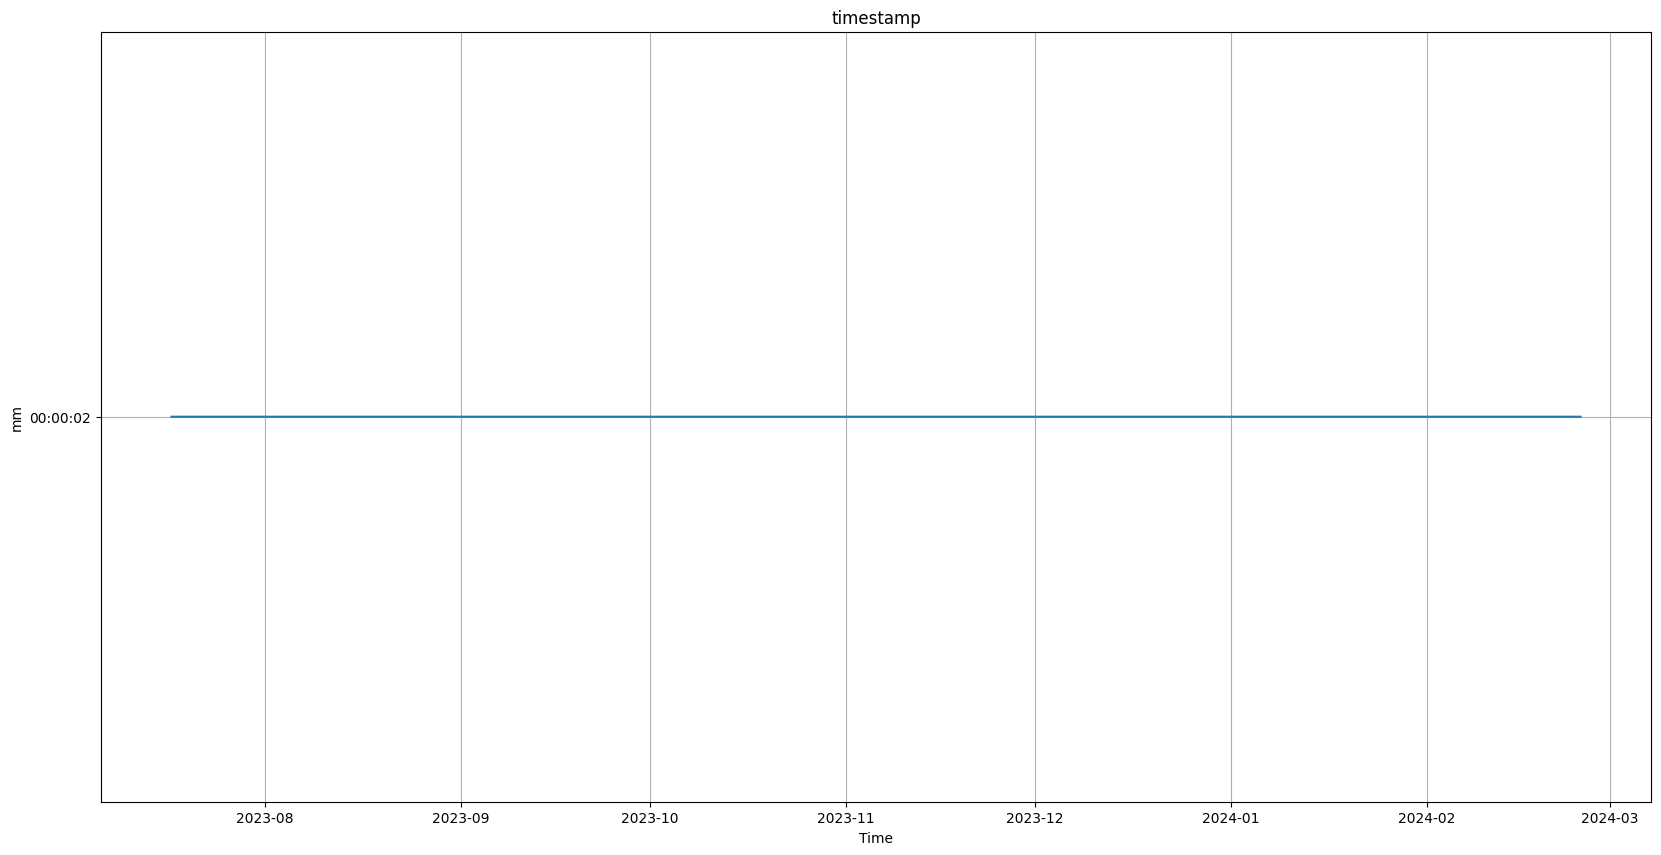

In [76]:
# 迴圈查詢結果中的每個表格
for table in result:
    # 從表格的第一條記錄中獲得欄位名稱（_field）
    field_name = table.records[0].values['_field']
    
    # 提取每個記錄的數據值（_value）
    data = [data.values['_value'] for data in table.records]
    
    # 提取每個記錄的時間戳（_time）
    time = [data.values['_time'] for data in table.records]

    # 設置繪圖的圖形大小
    plt.figure(figsize=(20, 10))
    
    # 設置圖形的標題和 x 軸標籤
    plt.title(field_name)
    plt.xlabel("Time")
    
    # 根據欄位名稱確定 y 軸標籤
    units = {"bat_a": "mA", "bat_v": "V", "s_ec2": "EC", "s_ph2": "pH"}
    ylabel = units.get(field_name, "mm")
    plt.ylabel(ylabel)
    
    # 新增網格線
    plt.grid(True)
    
    # 繪製時間序列數據
    plt.plot(time, data, label=field_name)
